In [2]:
import pandas as pd
import numpy as np
import glob, os
import scipy
from scipy import optimize as op
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

**Logistic Regression
Question 2 part a**

In [8]:
###### Sigmoid
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

##### Cost function with regularization
def cf_reg(w, x, y, l):
    m = len(y)
    h = sigmoid(x.dot(w))
    reg = (l/(2 * m)) * np.sum(w**2)

    return (1 / m) * (-y.T.dot(np.log(h)) - (1 - y).T.dot(np.log(1 - h))) + reg

##### gradient function with cost optimization
def grad_reg(w, x, y, l ):
    m, n = x.shape
    w = w.reshape((n, 1))
    y = y.reshape((m, 1))
    h = sigmoid(x.dot(w))
    reg = l* w /m

    return ((1 / m) * x.T.dot(h - y)) + reg

#### logistic regression function
def logistic(w,x,y,l):
    x = x.values
    y = y.values
    res = op.minimize(fun = cf_reg, x0 = w, args = (x, y,l),method = 'TNC', jac = grad_reg)
    return res.x

 **Data preprocessing for the CSV file
 Question 2 part b**

In [3]:
d_path = os.getcwd()
f = pd.read_csv(d_path + '/chronic_kidney_disease_full.csv',sep =",")
f = f.replace({'\t': ''}, regex=True)
# print(f.dtypes) --- use this to see datatypes of the columns
###### 
# As we see from the dtypes wbcc and rbcc should be float64 but are instead object so 
#  next line converts them to numerical (according to the info file)
# Same is the case with columns sg,Al and Su, which should be nominal but are read as float 64 here so we 
# change them too.
#######
f['wbcc'] = pd.to_numeric(f['wbcc'],errors='coerce')
f['rbcc'] = pd.to_numeric(f['rbcc'],errors='coerce')
f['sg'] = f['sg'].astype('object',errors='ignore')
f['al'] = f['al'].astype('object',errors='ignore')
f['su'] = f['su'].astype('object',errors='ignore')



print('=======================================')
print('Column types according the chronic_kidney_disease.info are')
print(f.dtypes)

Column types according the chronic_kidney_disease.info are
age      float64
bp       float64
sg        object
al        object
su        object
rbc       object
pc        object
pcc       object
ba        object
bgr      float64
bu       float64
sc       float64
sod      float64
pot      float64
hemo     float64
pcv      float64
wbcc     float64
rbcc     float64
htn       object
dm        object
cad       object
appet     object
pe        object
ane       object
class     object
dtype: object


In [4]:
#### please run this cell only after the cell above is run or else this won't print value counts 

obj = f.select_dtypes(['object']).columns

##### In next loop we convert all columns with dtype object to numerical codes
for col in obj:
    f[col] = f[col].astype('category').cat.codes
#     print(col ,"\n",f[col].value_counts())
###### Now we replace all Nan in float columns with their mean
f = f.fillna(f.mean())

f.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,3,1,0,-1,1,0,0,121.000000,...,44.0,7800.0,5.200000,1,2,0,0,0,0,0
1,7.0,50.0,3,4,0,-1,1,0,0,148.036517,...,38.0,6000.0,4.707435,0,1,0,0,0,0,0
2,62.0,80.0,1,2,3,1,1,0,0,423.000000,...,31.0,7500.0,4.707435,0,2,0,1,0,1,0
3,48.0,70.0,0,4,0,1,0,1,0,117.000000,...,32.0,6700.0,3.900000,1,1,0,1,1,1,0
4,51.0,80.0,1,2,0,1,1,0,0,106.000000,...,35.0,7300.0,4.600000,0,1,0,0,0,0,0


**Splitting data and getting graphs for training and testing data **

In [9]:
if 'intercept' not in f.columns:
    f.insert(loc = 0 , column='intercept', value=np.ones((f.shape[0], 1)))

train, test = train_test_split(f, test_size=0.2,stratify = f['class'])
y = train['class']
x = train.loc[:, train.columns != 'class']
w = np.zeros(x.shape[1])

p_train = []
p_test = []
i = - 2.0
while i < 4.001:
    model = logistic(w,x,y,l = i )
    
    train['pred_train'] = sigmoid(np.dot(train.iloc[:,:25].values,model.T))
    train['pred_train'] = np.where(train['pred_train']>= 0.5, 1 , 0)
    p_train.append([i,f1_score(train['class'], train['pred_train'])])
#     print(i,f1_score(train['class'], train['pred_train']))

    test['pred_test'] = sigmoid(np.dot(test.iloc[:,:25].values,model.T))
    test['pred_test'] = np.where(test['pred_test']>= 0.5, 1 , 0)
    p_test.append([i,f1_score(test['class'], test['pred_test'])])
#     print(i,f1_score(test['class'], test['pred_test']))
    i += 0.2
#     print('========================================')

l_train = pd.DataFrame(p_train,columns = ['Lambda','F1_score'])
l_test = pd.DataFrame(p_test,columns = ['Lambda','F1_score'])

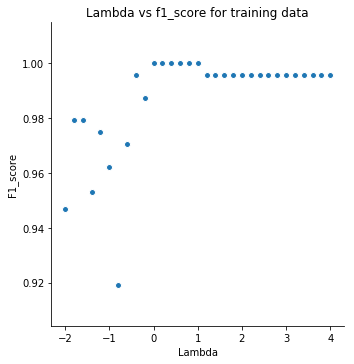

In [10]:
sns.pairplot(x_vars = 'Lambda' , y_vars = 'F1_score', data = l_train ,size = 5)
plt.title('Lambda vs f1_score for training data')
plt.show()

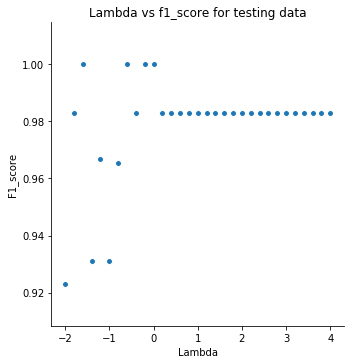

In [11]:
sns.pairplot(x_vars = 'Lambda' , y_vars = 'F1_score', data = l_test ,size = 5)
plt.title('Lambda vs f1_score for testing data')
plt.show()

**Question 2 part c Normalizing data **

In [8]:
scaler = StandardScaler()
if 'intercept' in f.columns:
    f = f.drop(columns = ['intercept'])
f_n = pd.DataFrame(scaler.fit_transform(f.loc[:, f.columns != 'class']))
f_n['class'] = f['class']


In [9]:
if 'intercept' not in f_n.columns:
    f_n.insert(loc = 0 , column='intercept', value=np.ones((f_n.shape[0], 1)))

train_n, test_n = train_test_split(f_n, test_size=0.2,stratify = f_n['class'])
y = train_n['class']
x = train_n.loc[:, train_n.columns != 'class']
w = np.zeros(x.shape[1])

p_train_n = []
p_test_n = []
i = - 2.0
while i < 4.001:
    model_n = logistic(w,x,y,l = i )
    
    train_n['pred_train_n'] = sigmoid(np.dot(train_n.iloc[:,:25].values,model_n.T))
    train_n['pred_train_n'] = np.where(train_n['pred_train_n']>= 0.5, 1 , 0)
    p_train_n.append([i,f1_score(train_n['class'], train_n['pred_train_n'])])
#     print(i,f1_score(train_n['class'], train_n['pred_train_n']))

    test_n['pred_test_n'] = sigmoid(np.dot(test_n.iloc[:,:25].values,model.T))
    test_n['pred_test_n'] = np.where(test_n['pred_test_n']>= 0.5, 1 , 0)
    p_test_n.append([i,f1_score(test_n['class'], test_n['pred_test_n'])])
#     print(i,f1_score(test_n['class'], test_n['pred_test_n']))
    i += 0.2
#     print('========================================')

l_train_n = pd.DataFrame(p_train_n,columns = ['Lambda','F1_score'])
l_test_n = pd.DataFrame(p_test_n,columns = ['Lambda','F1_score'])

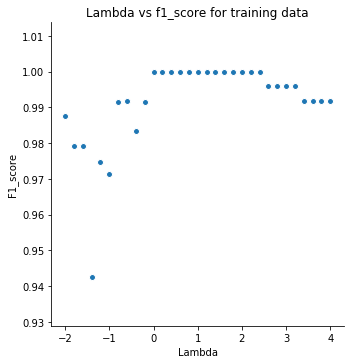

In [15]:
sns.pairplot(x_vars = 'Lambda' , y_vars = 'F1_score', data = l_train ,size = 5)
plt.title('Lambda vs f1_score for training data')
plt.show()

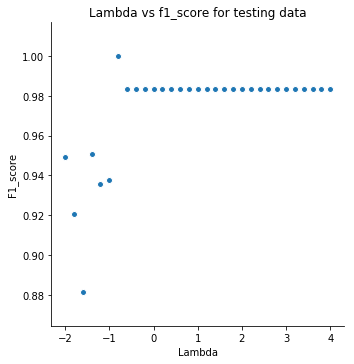

In [10]:
sns.pairplot(x_vars = 'Lambda' , y_vars = 'F1_score', data = l_test ,size = 5)
plt.title('Lambda vs f1_score for testing data')
plt.show()